In [1]:
!wget 'https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo-object-detection.zip'

--2021-04-03 15:39:52--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo-object-detection.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.137.128
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308184552 (294M) [application/zip]
Saving to: ‘yolo-object-detection.zip’

yolo-object-detecti 100%[===================>] 293.91M  74.9MB/s    in 3.7s    

2021-04-03 15:39:56 (79.2 MB/s) - ‘yolo-object-detection.zip’ saved [308184552/308184552]



In [2]:
!unzip '/content/yolo-object-detection.zip'

Archive:  /content/yolo-object-detection.zip
   creating: yolo-object-detection/
   creating: yolo-object-detection/images/
  inflating: yolo-object-detection/images/baggage_claim.jpg  
 extracting: yolo-object-detection/images/dining_table.jpg  
  inflating: yolo-object-detection/images/living_room.jpg  
  inflating: yolo-object-detection/images/soccer.jpg  
   creating: yolo-object-detection/output/
   creating: yolo-object-detection/videos/
  inflating: yolo-object-detection/videos/airport.mp4  
  inflating: yolo-object-detection/videos/car_chase_01.mp4  
  inflating: yolo-object-detection/videos/car_chase_02.mp4  
  inflating: yolo-object-detection/videos/overpass.mp4  
   creating: yolo-object-detection/yolo-coco/
  inflating: yolo-object-detection/yolo-coco/coco.names  
  inflating: yolo-object-detection/yolo-coco/yolov3.cfg  
  inflating: yolo-object-detection/yolo-coco/yolov3.weights  
  inflating: yolo-object-detection/yolo.py  
  inflating: yolo-object-detection/yolo_video.py

In [3]:
!git clone https://github.com/abewley/sort.git

Cloning into 'python-traffic-counter-with-yolo-and-sort'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


'/content/sort.py'

In [5]:
!pip install filterpy==1.1.0

     |████████████████████████████████| 71kB 6.3MB/s 
  Created wheel for filterpy: filename=filterpy-1.1.0-cp37-none-any.whl size=85417 sha256=b85d7d58293f3c12c563403657abea779f15912dadf72c27f6d9dc7ff0855cd5
  Stored in directory: /root/.cache/pip/wheels/ea/18/ee/d5ca9a957716ea3aee5acd3b5ba8ad733d5f5c1586ef3ac5b2
Successfully built filterpy


In [4]:
import numpy as np
import argparse
import imutils
import time

import cv2
import os
import glob
from google.colab.patches import cv2_imshow

from sort import *

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


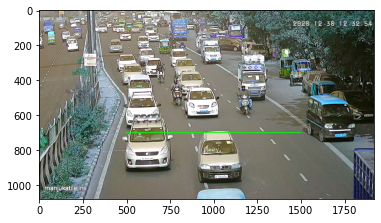

In [10]:
import matplotlib.pyplot as plt
vs = cv2.VideoCapture("/content/drive/MyDrive/object tracking traffic videos/20201230123300.mp4")
_, frame = vs.read()
cv2.line(frame,(500,700),(1500,700),(0,255,0),3)
plt.imshow(frame)
plt.show()

In [11]:

tracker = Sort()
memory = {}
line = [(500, 700), (1550, 700)]
counter = 0



# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
	return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def ccw(A,B,C):
	return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# load the COCO class labels our YOLO model was trained on
weightsPath = '/content/yolo-object-detection/yolo-coco/yolov3.weights'
configPath = '/content/yolo-object-detection/yolo-coco/yolov3.cfg'
labelsPath = '/content/yolo-object-detection/yolo-coco/coco.names'
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(200, 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration


# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture("/content/drive/MyDrive/object tracking traffic videos/20201230123300.mp4")
writer = None
(W, H) = (None, None)

frameIndex = 0

# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (218, 218),
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()

	# initialize our lists of detected bounding boxes, confidences,
	# and class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > 0.5:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates,
				# confidences, and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
	
	dets = []
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])
			dets.append([x, y, x+w, y+h, confidences[i]])

	np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
	dets = np.asarray(dets)
	tracks = tracker.update(dets)

	boxes = []
	indexIDs = []
	c = []
	previous = memory.copy()
	memory = {}

	for track in tracks:
		boxes.append([track[0], track[1], track[2], track[3]])
		indexIDs.append(int(track[4]))
		memory[indexIDs[-1]] = boxes[-1]

	if len(boxes) > 0:
		i = int(0)
		for box in boxes:
			# extract the bounding box coordinates
			(x, y) = (int(box[0]), int(box[1]))
			(w, h) = (int(box[2]), int(box[3]))

			# draw a bounding box rectangle and label on the image
			# color = [int(c) for c in COLORS[classIDs[i]]]
			# cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

			color = [int(c) for c in COLORS[indexIDs[i] % len(COLORS)]]
			cv2.rectangle(frame, (x, y), (w, h), color, 2)

			if indexIDs[i] in previous:
				previous_box = previous[indexIDs[i]]
				(x2, y2) = (int(previous_box[0]), int(previous_box[1]))
				(w2, h2) = (int(previous_box[2]), int(previous_box[3]))
				p0 = (int(x + (w-x)/2), int(y + (h-y)/2))
				p1 = (int(x2 + (w2-x2)/2), int(y2 + (h2-y2)/2))
				cv2.line(frame, p0, p1, color, 3)

				if intersect(p0, p1, line[0], line[1]):
					counter += 1

			# text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			text = "{}".format(indexIDs[i])
			cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
			i += 1

	# draw line
	cv2.line(frame, line[0], line[1], (0, 255, 255), 5)

	# draw counter
	cv2.putText(frame, str(counter), (100,200), cv2.FONT_HERSHEY_DUPLEX, 5.0, (0, 255, 255), 10)
	# counter += 1

	# saves image file
	cv2.imwrite("outputsss/frame-{}.png".format(frameIndex), frame)

	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter("/content/drive/MyDrive/object tracking traffic videos/outs4.avi", fourcc, 25,
			(frame.shape[1], frame.shape[0]), True)

		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time to finish: {:.4f}".format(
				elap * total))

	# write the output frame to disk
	writer.write(frame)

	# increase frame index
	frameIndex += 1

	if frameIndex >= 4000:
		print("[INFO] cleaning up...")
		writer.release()
		vs.release()
		exit()

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] loading YOLO from disk...
[INFO] 736 total frames in video
[INFO] single frame took 0.6558 seconds
[INFO] estimated total time to finish: 482.6505


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


[INFO] cleaning up...


Initialized empty Git repository in /content/.git/


usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-regex]
    --get-all             get all values: key [value-regex]
    --get-regexp          get values for regexp: name-regex [value-regex]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value_regex]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-regex]
    --unset-all           remove all matches: name [value-regex]
    --rename-section      rename section: old-name new-name
    --remove-section      remove a section: name
    -l, --list            list all
 

error: open("drive/MyDrive/1704060.gslides"): Operation not supported
error: unable to index file drive/MyDrive/1704060.gslides
fatal: adding files failed
